In [1]:
import sys
import os

# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Moves up one level

# Add the project root to sys.path
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
from operator import itemgetter

from tqdm import tqdm

import h5py
import pickle
import matplotlib.pyplot as plt

In [3]:
id2label = ["Cat", "Car", "Dog", "Deer", "Bird", "Airplane", "Monkey", "Ship", "Horse", "Truck (Drift)"]

In [4]:
def visualize_images(data, n=5, save=False, filename="output.pdf"):
    plt.figure(figsize=(20, 10))
    
    for i in range(min(n, len(data))):
        entry = data[i]  # Each entry is a NumPy array of shape (2,)

        # Extract image from the first element
        if isinstance(entry, np.ndarray) and entry.shape == (2,):
            img = entry[0]  # Image is stored in the first element
            label = entry[1]  # Label or metadata
        else:
            img = entry

        # Ensure the extracted part is a NumPy array
        if not isinstance(img, np.ndarray):
            print(f"Skipping index {i}: Not an ndarray")
            continue

        # Plot image
        plt.subplot(1, n, i + 1)
        plt.imshow(img)  # Automatically handles grayscale/RGB
        plt.axis("off")

    # Further reduce horizontal space between images by adjusting wspace
    plt.subplots_adjust(wspace=0.02)  # Reduced space between images

    # Save the figure as a high-quality PDF if save is True
    if save:
        plt.savefig(filename, format='pdf', dpi=300, bbox_inches='tight')

    plt.show()


# Load Embedding Vectors and Images

In [5]:
def load_embedding(filepath, E_name=None, Y_original_name=None, Y_predicted_name=None):
    if filepath is not None:
        with h5py.File(filepath, "r") as hf:
            if E_name is None:
                E = hf["E"][()]
            else:
                E = hf[E_name][()]
            if Y_original_name is None:
                Y_original = hf["Y_original"][()]
            else:
                Y_original = hf[Y_original_name][()]
            if Y_predicted_name is None:
                Y_predicted = hf["Y_predicted"][()]
            else:
                Y_predicted = hf[Y_predicted_name][()]
    else:
        raise Exception("Error in loading the embedding file. Please set the embedding paths in the configuration file.")
    return E, Y_original, Y_predicted

In [6]:
import os
import cv2

def load_images_from_folder(folder_path):
    """
    Load all PNG images from a specified folder in numerical order.

    :param folder_path: Path to the folder containing images.
    :return: List of images as NumPy arrays.
    """
    images = []
    
    # Get all PNG files and sort them numerically
    filenames = sorted(
        [f for f in os.listdir(folder_path) if f.lower().endswith(".png")],
        key=lambda x: int(os.path.splitext(x)[0])  # Convert filename (without extension) to an integer
    )

    for filename in filenames:
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)  # Load image using OpenCV
        if image is not None:
            images.append(image)

    return images


In [7]:
base_path = "../experiments/use_case_6_stl_truck_drift/static/saved_embeddings/vit/"

E_train, Y_original_train, Y_predicted_train = load_embedding(os.path.join(base_path, "train_embedding.hdf5"))
E_test, Y_original_test, Y_predicted_test = load_embedding(os.path.join(base_path, "test_embedding.hdf5"))
E_new_unseen, Y_original_new_unseen, Y_predicted_new_unseen = load_embedding(os.path.join(base_path, "new_unseen_embedding.hdf5"))
E_drift, Y_original_drift, Y_predicted_drift = load_embedding(os.path.join(base_path, "drift_embedding.hdf5"))

In [8]:
train_filepath = "/Users/salvatorephd/PycharmProjects/drift-lens/experiments/use_case_6_stl_truck_drift/static/data/stl images/train"
test_filepath = "/Users/salvatorephd/PycharmProjects/drift-lens/experiments/use_case_6_stl_truck_drift/static/data/stl images/test"
new_unseen_filepath = "/Users/salvatorephd/PycharmProjects/drift-lens/experiments/use_case_6_stl_truck_drift/static/data/stl images/new_unseen"
drift_filepath = "/Users/salvatorephd/PycharmProjects/drift-lens/experiments/use_case_6_stl_truck_drift/static/data/stl images/drift"

In [9]:
# Load the datasets
train_images = load_images_from_folder(train_filepath)
test_images = load_images_from_folder(test_filepath)
new_unseen_images = load_images_from_folder(new_unseen_filepath)
drift_images = load_images_from_folder(drift_filepath)

In [10]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_new_unseen = pd.DataFrame()
df_drift = pd.DataFrame()

In [11]:
df_train["original_label"] = Y_original_train
df_train["predicted_label"] = Y_predicted_train
df_train["predicted_label_name"] = df_train["predicted_label"].apply(lambda x: id2label[x])
df_train["original_label_name"] = df_train["original_label"].apply(lambda x: id2label[x])
df_train["text"] = df_train.apply(lambda row: f'Original: {row["original_label_name"]} - Predicted: {row["predicted_label_name"]}', axis=1)
df_train["drifted_label"] = [0]*len(df_train)

df_test["original_label"] = Y_original_test
df_test["predicted_label"] = Y_predicted_test
df_test["predicted_label_name"] = df_test["predicted_label"].apply(lambda x: id2label[x])
df_test["original_label_name"] = df_test["original_label"].apply(lambda x: id2label[x])
df_test["text"] = df_test.apply(lambda row: f'Original: {row["original_label_name"]} - Predicted: {row["predicted_label_name"]}', axis=1)
df_test["drifted_label"] = [0]*len(df_test)

df_new_unseen["original_label"] = Y_original_new_unseen
df_new_unseen["predicted_label"] = Y_predicted_new_unseen
df_new_unseen["predicted_label_name"] = df_new_unseen["predicted_label"].apply(lambda x: id2label[x])
df_new_unseen["original_label_name"] = df_new_unseen["original_label"].apply(lambda x: id2label[x])
df_new_unseen["text"] = df_new_unseen.apply(lambda row: f'Original: {row["original_label_name"]} - Predicted: {row["predicted_label_name"]}', axis=1)
df_new_unseen["drifted_label"] = [0]*len(df_new_unseen)

df_drift["original_label"] = Y_original_drift
df_drift["predicted_label"] = Y_predicted_drift
df_drift["predicted_label_name"] = df_drift["predicted_label"].apply(lambda x: id2label[x])
df_drift["original_label_name"] = df_drift["original_label"].apply(lambda x: id2label[x])
df_drift["text"] = df_drift.apply(lambda row: f'Original: {row["original_label_name"]} - Predicted: {row["predicted_label_name"]}', axis=1)
df_drift["drifted_label"] = [1]*len(df_drift)

In [12]:
df_train.head()

original_label  predicted_label predicted_label_name original_label_name  \
0               0                0                  Cat                 Cat   
1               5                5             Airplane            Airplane   
2               3                3                 Deer                Deer   
3               2                2                  Dog                 Dog   
4               1                1                  Car                 Car   

                                       text  drifted_label  
0            Original: Cat - Predicted: Cat              0  
1  Original: Airplane - Predicted: Airplane              0  
2          Original: Deer - Predicted: Deer              0  
3            Original: Dog - Predicted: Dog              0  
4            Original: Car - Predicted: Car              0

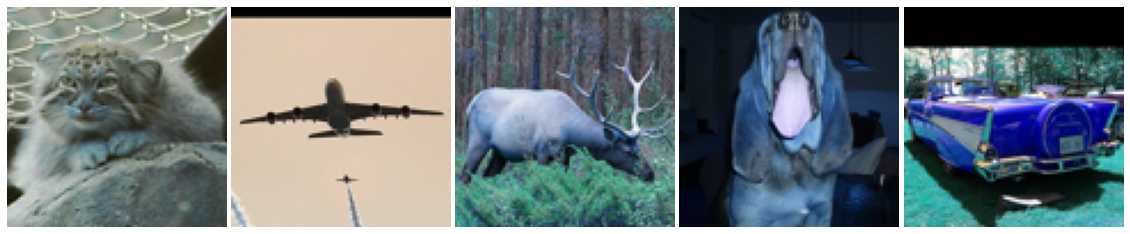

In [13]:
visualize_images(train_images, n=5)

In [14]:
df_test.head()

original_label  predicted_label predicted_label_name original_label_name  \
0               8                8                Horse               Horse   
1               0                0                  Cat                 Cat   
2               6                6               Monkey              Monkey   
3               2                8                Horse                 Dog   
4               8                8                Horse               Horse   

                                   text  drifted_label  
0    Original: Horse - Predicted: Horse              0  
1        Original: Cat - Predicted: Cat              0  
2  Original: Monkey - Predicted: Monkey              0  
3      Original: Dog - Predicted: Horse              0  
4    Original: Horse - Predicted: Horse              0

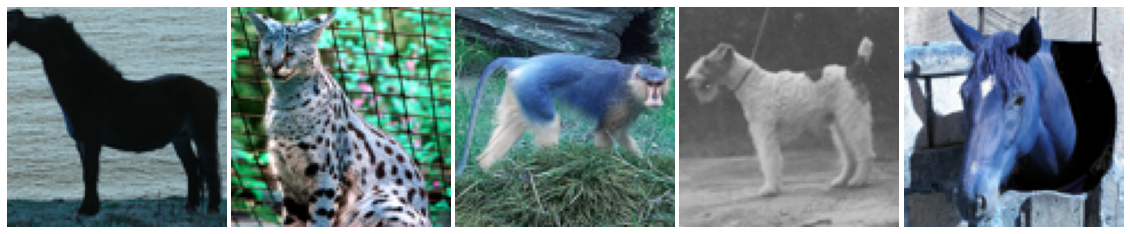

In [15]:
visualize_images(test_images, n=5)

In [16]:
df_new_unseen.head()

original_label  predicted_label predicted_label_name original_label_name  \
0               1                1                  Car                 Car   
1               5                5             Airplane            Airplane   
2               4                4                 Bird                Bird   
3               0                0                  Cat                 Cat   
4               7                7                 Ship                Ship   

                                       text  drifted_label  
0            Original: Car - Predicted: Car              0  
1  Original: Airplane - Predicted: Airplane              0  
2          Original: Bird - Predicted: Bird              0  
3            Original: Cat - Predicted: Cat              0  
4          Original: Ship - Predicted: Ship              0

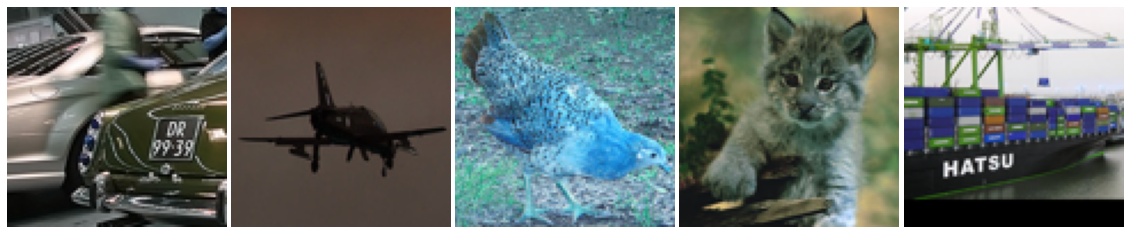

In [17]:
visualize_images(new_unseen_images, n=5)

In [18]:
df_drift.head()

original_label  predicted_label predicted_label_name original_label_name  \
0               9                7                 Ship       Truck (Drift)   
1               9                7                 Ship       Truck (Drift)   
2               9                1                  Car       Truck (Drift)   
3               9                1                  Car       Truck (Drift)   
4               9                1                  Car       Truck (Drift)   

                                        text  drifted_label  
0  Original: Truck (Drift) - Predicted: Ship              1  
1  Original: Truck (Drift) - Predicted: Ship              1  
2   Original: Truck (Drift) - Predicted: Car              1  
3   Original: Truck (Drift) - Predicted: Car              1  
4   Original: Truck (Drift) - Predicted: Car              1

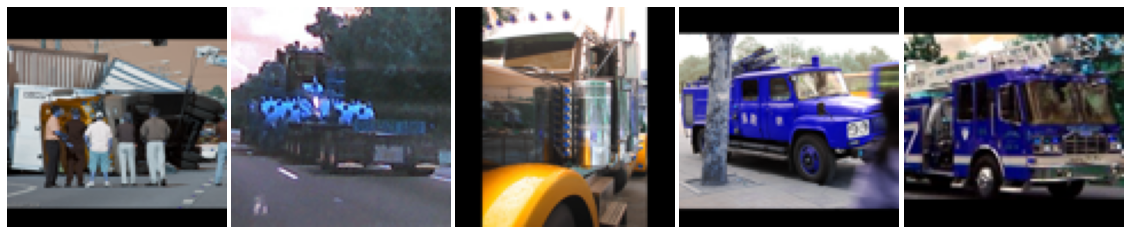

In [19]:
visualize_images(drift_images, n=5)

# Reduce Embedding Dimensionality

In [20]:
flag_reduce_with_baseline = False

if flag_reduce_with_baseline:
    print("Embdding dimensionality reduction with baseline PCA ...")
    dl = DriftLens()
    
    baseline = dl.estimate_baseline(E=E_train,
                                Y=Y_predicted_train,
                                label_list=range(len(id2label)-1),
                                batch_n_pc=150,
                                per_label_n_pc=75)

    E_train_per_label_reduced = []

    for E, Y_predicted in zip(E_train, Y_predicted_train):
        pca_model = baseline.get_PCA_model_by_label(Y_predicted)

        # Ensure E is a 2D array before PCA transformation
        if E.ndim == 1:  # If E is a 1D vector
            E = E.reshape(1, -1)  # Reshape to (1, num_features)

        # Apply PCA transformation
        E_pca = pca_model.transform(E)  # This should be (1, reduced_dim)

        # Reshape E_pca to ensure final shape is (1, reduced_dim) without unnecessary dimensions
        E_train_per_label_reduced.append(E_pca.squeeze())  

    # Convert list to numpy array
    E_train_per_label_reduced = np.array(E_train_per_label_reduced)

    # Check the final shape of E_drift_reduced
    print(E_train_per_label_reduced.shape)
    
    E_test_per_label_reduced = []

    for E, Y_predicted in zip(E_test, Y_predicted_test):
        pca_model = baseline.get_PCA_model_by_label(Y_predicted)

        # Ensure E is a 2D array before PCA transformation
        if E.ndim == 1:  # If E is a 1D vector
            E = E.reshape(1, -1)  # Reshape to (1, num_features)

        # Apply PCA transformation
        E_pca = pca_model.transform(E)  # This should be (1, reduced_dim)

        # Reshape E_pca to ensure final shape is (1, reduced_dim) without unnecessary dimensions
        E_test_per_label_reduced.append(E_pca.squeeze())  

    # Convert list to numpy array
    E_test_per_label_reduced = np.array(E_test_per_label_reduced)

    # Check the final shape of E_drift_reduced
    print(E_test_per_label_reduced.shape)
    
    E_new_unseen_per_label_reduced = []

    for E, Y_predicted in zip(E_new_unseen, Y_predicted_new_unseen):
        pca_model = baseline.get_PCA_model_by_label(Y_predicted)

        # Ensure E is a 2D array before PCA transformation
        if E.ndim == 1:  # If E is a 1D vector
            E = E.reshape(1, -1)  # Reshape to (1, num_features)

        # Apply PCA transformation
        E_pca = pca_model.transform(E)  # This should be (1, reduced_dim)

        # Reshape E_pca to ensure final shape is (1, reduced_dim) without unnecessary dimensions
        E_new_unseen_per_label_reduced.append(E_pca.squeeze())  

    # Convert list to numpy array
    E_new_unseen_per_label_reduced = np.array(E_new_unseen_per_label_reduced)

    # Check the final shape of E_drift_reduced
    print(E_new_unseen_per_label_reduced.shape)
    
    E_drift_per_label_reduced = []

    for E, Y_predicted in zip(E_drift, Y_predicted_drift):
        pca_model = baseline.get_PCA_model_by_label(Y_predicted)

        # Ensure E is a 2D array before PCA transformation
        if E.ndim == 1:  # If E is a 1D vector
            E = E.reshape(1, -1)  # Reshape to (1, num_features)

        # Apply PCA transformation
        E_pca = pca_model.transform(E)  # This should be (1, reduced_dim)

        # Reshape E_pca to ensure final shape is (1, reduced_dim) without unnecessary dimensions
        E_drift_per_label_reduced.append(E_pca.squeeze())  

    # Convert list to numpy array
    E_drift_per_label_reduced = np.array(E_drift_per_label_reduced)

    # Check the final shape of E_drift_reduced
    print(E_drift_per_label_reduced.shape)

    E_train_per_batch_reduced = baseline.get_batch_PCA_model().transform(E_train)
    E_test_per_batch_reduced = baseline.get_batch_PCA_model().transform(E_test)
    E_new_unseen_per_batch_reduced = baseline.get_batch_PCA_model().transform(E_new_unseen)
    E_drift_per_batch_reduced = baseline.get_batch_PCA_model().transform(E_drift)

else:
    print("Embdding dimensionality reduction with baseline PCA skipped")
    E_train_per_label_reduced = E_train
    E_train_per_batch_reduced = E_train

    E_test_per_label_reduced = E_test
    E_test_per_batch_reduced = E_test

    E_new_unseen_per_label_reduced = E_new_unseen
    E_new_unseen_per_batch_reduced = E_new_unseen

    E_drift_per_label_reduced = E_drift
    E_drift_per_batch_reduced = E_drift



Embdding dimensionality reduction with baseline PCA skipped


In [21]:
print(E_train_per_label_reduced.shape)
print(E_test_per_label_reduced.shape)
print(E_new_unseen_per_label_reduced.shape)
print(E_drift_per_label_reduced.shape)

(5850, 768)
(2925, 768)
(2925, 768)
(1300, 768)


In [22]:
print(E_train_per_batch_reduced.shape)
print(E_test_per_batch_reduced.shape)
print(E_new_unseen_per_batch_reduced.shape)
print(E_drift_per_batch_reduced.shape)

(5850, 768)
(2925, 768)
(2925, 768)
(1300, 768)


# Clustering Algorithms

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.preprocessing import normalize

def find_optimal_clusters_with_spectral(embeddings, max_clusters=10, reduce_dim=False, n_dim=2, affinity='nearest_neighbors', plot=False):
    if reduce_dim:
        pca = PCA(n_components=n_dim)
        embeddings = pca.fit_transform(embeddings)
    
    silhouette_scores = []
    
    for k in range(2, max_clusters + 1):
        clustering = SpectralClustering(n_clusters=k, affinity=affinity, random_state=42, assign_labels='kmeans')
        labels = clustering.fit_predict(embeddings)
        
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(embeddings, labels))
        else:
            silhouette_scores.append(None)
    
    best_k = np.argmax([s for s in silhouette_scores if s is not None]) + 2
    spectral_best = SpectralClustering(n_clusters=best_k, affinity=affinity, random_state=42, assign_labels='kmeans')
    labels = spectral_best.fit_predict(embeddings)
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette Score')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs. Clusters (Spectral)')
        plt.grid(True)
        plt.show()
    
    return best_k, spectral_best, labels

def find_optimal_clusters_with_kmeans(embeddings, max_clusters=10, reduce_dim=False, n_dim=2, max_iter=1000, plot=False):
    if reduce_dim:
        pca = PCA(n_components=n_dim)
        embeddings = pca.fit_transform(embeddings)
    
    silhouette_scores = []
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, max_iter=max_iter, n_init=10)
        labels = kmeans.fit_predict(embeddings)
        inertias.append(kmeans.inertia_)
        
        if k > 1:
            silhouette_scores.append(silhouette_score(embeddings, labels))
        else:
            silhouette_scores.append(None)
    
    best_k = np.argmax([s for s in silhouette_scores if s is not None]) + 2
    kmeans_best = KMeans(n_clusters=best_k, max_iter=max_iter, n_init=10)
    labels = kmeans_best.fit_predict(embeddings)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, max_clusters + 1), silhouette_scores[1:], marker='o', label='Silhouette Score')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs. Clusters')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(range(1, max_clusters + 1), inertias, marker='o', label='Inertia', color='orange')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.title('Inertia vs. Clusters')
        plt.grid(True)
        plt.show()
    
    return best_k, kmeans_best, labels

def find_optimal_clusters_with_gmm(embeddings, max_clusters=10, reduce_dim=False, n_dim=2, plot=False):
    if reduce_dim:
        pca = PCA(n_components=n_dim)
        embeddings = pca.fit_transform(embeddings)
    
    silhouette_scores = []
    bic_scores = []
    
    for k in range(2, max_clusters + 1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        labels = gmm.fit_predict(embeddings)
        bic_scores.append(gmm.bic(embeddings))
        
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(embeddings, labels))
        else:
            silhouette_scores.append(None)
    
    best_k = np.argmax([s for s in silhouette_scores if s is not None]) + 2
    gmm_best = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
    labels = gmm_best.fit_predict(embeddings)
    
    if plot:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', label='Silhouette Score')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score vs. Clusters')
        plt.grid(True)
    
        plt.subplot(1, 2, 2)
        plt.plot(range(2, max_clusters + 1), bic_scores, marker='o', label='BIC', color='orange')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('BIC Score')
        plt.title('BIC Score vs. Clusters')
        plt.grid(True)
        plt.show()
    
    return best_k, gmm_best, labels



def get_centroids_and_closest_samples_spectral(embeddings, labels, k=5, distance_metric="euclidean"):
    """
    Compute pseudo-centroids (mean points) and find k closest samples to each centroid.
    """
    unique_labels = np.unique(labels)
    centroids = np.array([embeddings[labels == cluster_id].mean(axis=0) for cluster_id in unique_labels])
    
    distances = cdist(embeddings, centroids, metric=distance_metric)
    
    closest_samples = {}
    for i, cluster_id in enumerate(unique_labels):
        cluster_samples = np.where(labels == cluster_id)[0]
        cluster_distances = distances[cluster_samples, i]
        closest_k_indices = cluster_samples[np.argsort(cluster_distances)[:k]]
        closest_samples[cluster_id] = closest_k_indices.tolist()
    
    return centroids, closest_samples

def get_centroids_and_closest_samples_kmeans(embeddings, kmeans, labels, k=5, distance_metric="cosine"):
    """
    Find the centroids and the k closest samples to each centroid.
    
    Parameters:
    - embeddings (numpy array): High-dimensional input embeddings (n_samples, n_features).
    - kmeans (KMeans): Trained KMeans model.
    - labels (numpy array): Cluster labels for the embeddings.
    - k (int): Number of closest samples to return for each centroid.
    
    Returns:
    - centroids (numpy array): Coordinates of the centroids (n_clusters, n_features).
    - closest_samples (dict): Dictionary where keys are cluster IDs and values are lists of sample indices.
    """
    # Extract centroids from the KMeans
    centroids = kmeans.cluster_centers_  # Shape: (n_clusters, n_features)
    
    if distance_metric == "euclidean":
        # Calculate distances between each embedding and each centroid
        distances = cdist(embeddings, centroids, metric='euclidean')  # Shape: (n_samples, n_clusters)
    else:
        # Compute cosine distance
        distances = cdist(embeddings, centroids, metric='cosine')

    
    # Find the k closest samples for each centroid
    closest_samples = {}
    for cluster_id in range(len(centroids)):
        # Get indices of samples belonging to the current cluster
        cluster_samples = np.where(labels == cluster_id)[0]
        # Filter distances to only include samples in the current cluster
        cluster_distances = distances[cluster_samples, cluster_id]
        # Sort by distance and get the indices of the k smallest distances
        closest_k_indices = cluster_samples[np.argsort(cluster_distances)[:k]]
        closest_samples[cluster_id] = closest_k_indices.tolist()
    
    return centroids, closest_samples


def get_centroids_and_closest_samples_gmm(embeddings, gmm, labels, k=5, distance_metric="cosine"):
    """
    Find the centroids and the k closest samples to each centroid for GMM clusters.
    """
    centroids = gmm.means_
    
    distances = cdist(embeddings, centroids, metric=distance_metric)
    
    closest_samples = {}
    for cluster_id in range(len(centroids)):
        cluster_samples = np.where(labels == cluster_id)[0]
        cluster_distances = distances[cluster_samples, cluster_id]
        closest_k_indices = cluster_samples[np.argsort(cluster_distances)[:k]]
        closest_samples[cluster_id] = closest_k_indices.tolist()
    
    return centroids, closest_samples

In [24]:
def get_text_and_labels_from_ids(df, text_column, label_column, sample_ids):
    """
    Retrieve the text and labels for the given sample indices, using .iloc for integer-based indexing.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the text data.
    - text_column (str): Name of the column containing text.
    - label_column (str): Name of the column containing labels.
    - sample_ids (list): List of sample indices (integer positions).
    
    Returns:
    - List of tuples: Each tuple contains (text, label) corresponding to the indices.
    """
    return df.iloc[sample_ids][[text_column, label_column]].to_records(index=False).tolist()


In [25]:
from scipy.special import comb
from collections import Counter
from math import log2

def compute_purity(cluster_labels, true_labels):
    clusters = np.unique(cluster_labels)
    total_correct = 0
    
    for cluster in clusters:
        # Indices of samples in this cluster
        indices = np.where(cluster_labels == cluster)[0]
        # True labels for these samples
        true_labels_in_cluster = true_labels[indices]
        
        # Count occurrences of each true label and select the most common
        most_common_count = Counter(true_labels_in_cluster).most_common(1)[0][1]
        total_correct += most_common_count
    
    purity = total_correct / len(true_labels)
    return purity



# Drifted Window Prototypes

In [26]:
window_size = 2000
drift_percetage = 20

n_samples_drift = int((window_size*drift_percetage)/100)
samples_per_class = int((window_size - n_samples_drift) // (len(id2label)-1))

# Ensure there are enough samples in each group
if df_new_unseen["original_label"].value_counts().min() < samples_per_class:
    raise ValueError("Not enough samples in one or more groups to split equally.")

# Initialize an empty list to store indices
indices_new_unseen = []

# Iterate through each unique value in the "original_label" column
for label in df_new_unseen["original_label"].unique():
    # Get all indices for the current label
    label_indices = df_new_unseen[df_new_unseen["original_label"] == label].index
    # Randomly sample the specified number of indices
    sampled_indices = np.random.choice(label_indices, size=samples_per_class, replace=False)
    # Add the sampled indices to the list
    indices_new_unseen.extend(sampled_indices)

# Convert to a numpy array if needed
indices_new_unseen = np.array(indices_new_unseen)

# Randomly sample indices for df_drift and E_drift
indices_drift = np.random.choice(df_drift.index, size=n_samples_drift, replace=False)

# Sample both the DataFrame and the corresponding NumPy array
df_drifted_window_per_label = pd.concat([
    df_new_unseen.loc[indices_new_unseen].copy(),
    df_drift.loc[indices_drift].copy()
], axis=0).copy()

E_drifted_window_per_label = np.concatenate([
    E_new_unseen_per_label_reduced[indices_new_unseen],
    E_drift_per_label_reduced[indices_drift]
]).copy()


images_drifted_window = np.concatenate([
    np.array(list(itemgetter(*indices_new_unseen)(new_unseen_images))),
    np.array(list(itemgetter(*indices_drift)(drift_images)))
]).copy()

df_drifted_window_per_batch = pd.concat([
    df_new_unseen.loc[indices_new_unseen].copy(),
    df_drift.loc[indices_drift].copy()
], axis=0).copy()

E_drifted_window_per_batch = np.concatenate([
    E_new_unseen_per_batch_reduced[indices_new_unseen],
    E_drift_per_batch_reduced[indices_drift]
]).copy()




In [27]:
df_drifted_window_per_label.tail()

original_label  predicted_label predicted_label_name  \
675                9                7                 Ship   
655                9                1                  Car   
637                9                1                  Car   
1040               9                1                  Car   
140                9                1                  Car   

     original_label_name                                       text  \
675        Truck (Drift)  Original: Truck (Drift) - Predicted: Ship   
655        Truck (Drift)   Original: Truck (Drift) - Predicted: Car   
637        Truck (Drift)   Original: Truck (Drift) - Predicted: Car   
1040       Truck (Drift)   Original: Truck (Drift) - Predicted: Car   
140        Truck (Drift)   Original: Truck (Drift) - Predicted: Car   

      drifted_label  
675               1  
655               1  
637               1  
1040              1  
140               1

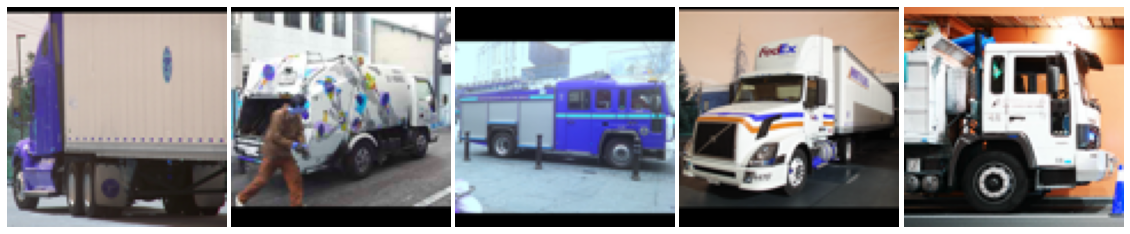

In [28]:
visualize_images(images_drifted_window[-5:], n=5)

## Per-label Explanations

In [29]:
clustering_algorithms = ["spectral", "kmeans", "gmm"]
clustering_algorithm_id = 1

closest_samples_distance_metrics = ["euclidean", "cosine"]
closest_samples_distance_metric_id = 0

label_ids_to_explain = [1, 5, 7]

max_clusters = 10

k = 4  # Number of closest samples to find as prototypes

flag_pca = False
pca_dims = 75

flag_normalize = False

print(f"Using {clustering_algorithms[clustering_algorithm_id]} with {closest_samples_distance_metrics[closest_samples_distance_metric_id]} distance to identify prototypes")


Using kmeans with euclidean distance to identify prototypes


Explainig Label: Car
9    223
1    174
Name: original_label, dtype: int64

Using kmeans algorithm

Cluster 0:

Prototype 0: Original: Car - Predicted: Car
Prototype 1: Original: Car - Predicted: Car
Prototype 2: Original: Car - Predicted: Car
Prototype 3: Original: Car - Predicted: Car


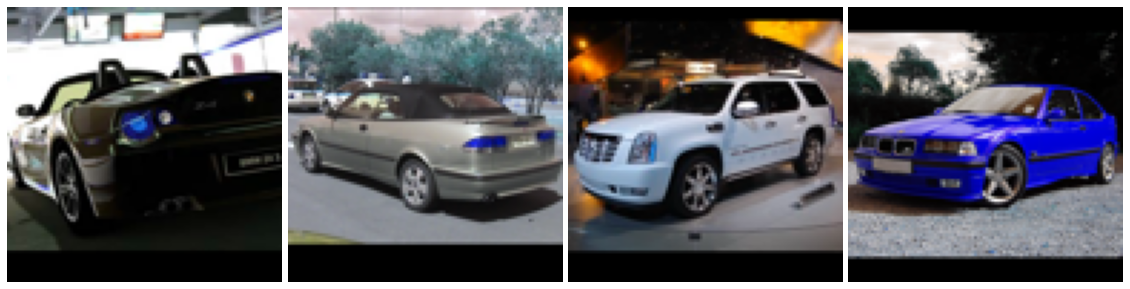




Cluster 1:

Prototype 0: Original: Truck (Drift) - Predicted: Car
Prototype 1: Original: Truck (Drift) - Predicted: Car
Prototype 2: Original: Truck (Drift) - Predicted: Car
Prototype 3: Original: Truck (Drift) - Predicted: Car


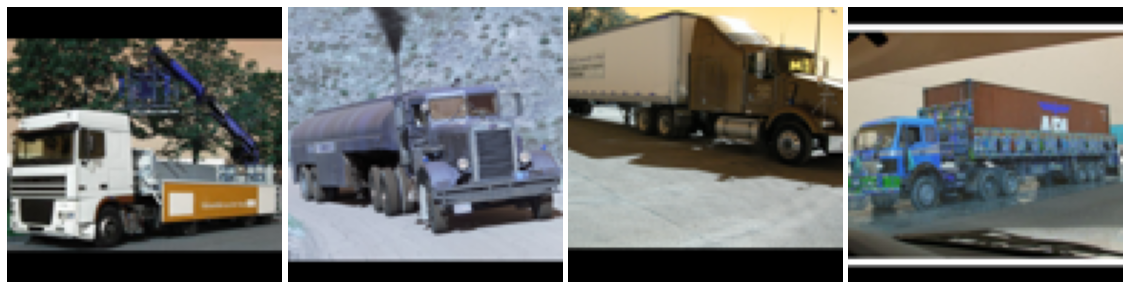



Explainig Label: Airplane
5    171
9     13
3      1
1      1
Name: original_label, dtype: int64

Using kmeans algorithm

Cluster 0:

Prototype 0: Original: Airplane - Predicted: Airplane
Prototype 1: Original: Airplane - Predicted: Airplane
Prototype 2: Original: Airplane - Predicted: Airplane
Prototype 3: Original: Airplane - Predicted: Airplane


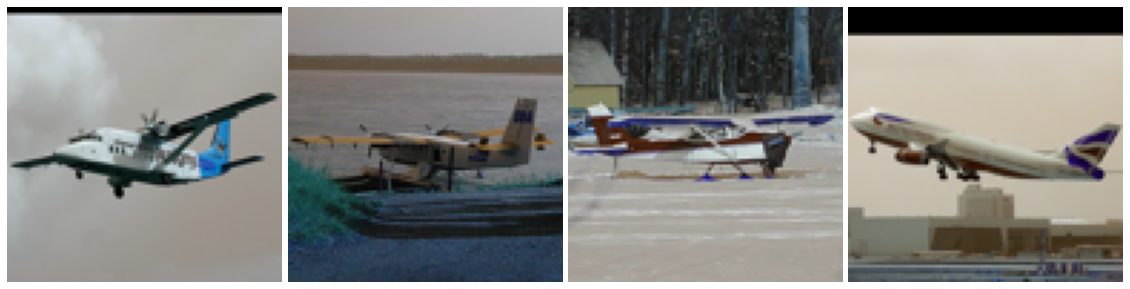




Cluster 1:

Prototype 0: Original: Truck (Drift) - Predicted: Airplane
Prototype 1: Original: Truck (Drift) - Predicted: Airplane
Prototype 2: Original: Truck (Drift) - Predicted: Airplane
Prototype 3: Original: Truck (Drift) - Predicted: Airplane


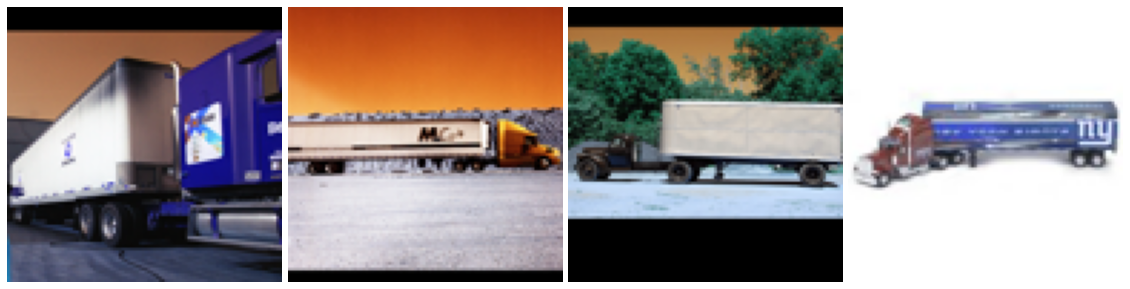



Explainig Label: Ship
7    177
9    164
5      6
8      2
1      2
Name: original_label, dtype: int64

Using kmeans algorithm

Cluster 0:

Prototype 0: Original: Ship - Predicted: Ship
Prototype 1: Original: Ship - Predicted: Ship
Prototype 2: Original: Ship - Predicted: Ship
Prototype 3: Original: Ship - Predicted: Ship


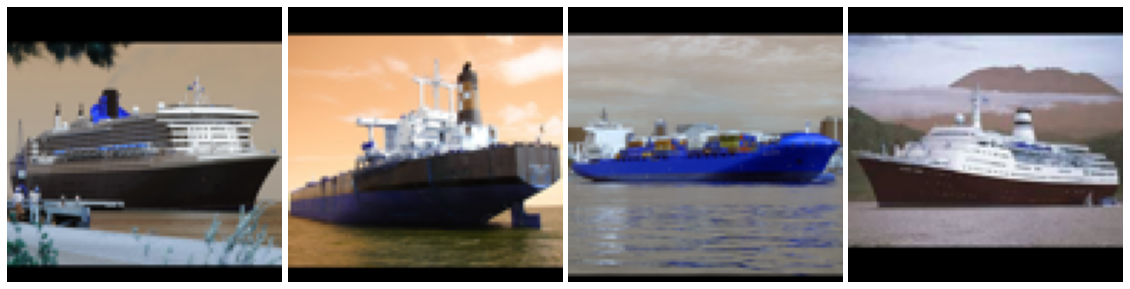




Cluster 1:

Prototype 0: Original: Truck (Drift) - Predicted: Ship
Prototype 1: Original: Truck (Drift) - Predicted: Ship
Prototype 2: Original: Truck (Drift) - Predicted: Ship
Prototype 3: Original: Truck (Drift) - Predicted: Ship


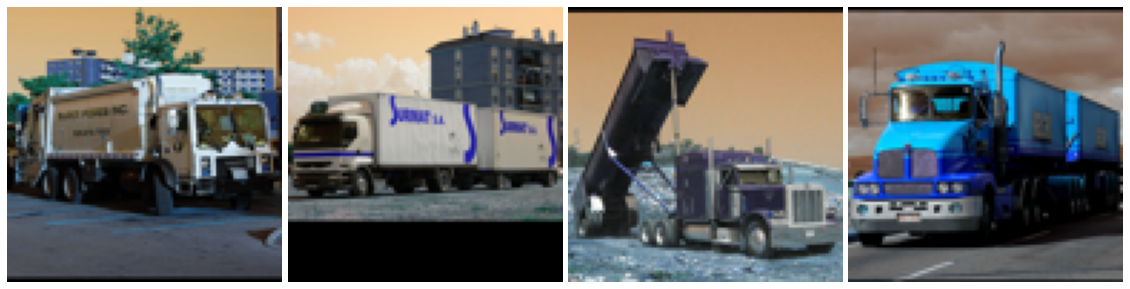

In [30]:
for label_id_to_explain in label_ids_to_explain:
    print(f"Explainig Label: {id2label[label_id_to_explain]}")
    
    indices_current_label = np.where(df_drifted_window_per_label.predicted_label.values == label_id_to_explain)[0]

    # Filter the DataFrame using the positional indices
    df_current_label = df_drifted_window_per_label.iloc[indices_current_label].copy()

    # Filter the NumPy array using the same positional indices
    E_current_label = E_drifted_window_per_label[indices_current_label]
    images_current_label = images_drifted_window[indices_current_label]
    
    
    if flag_pca:
        pca = PCA(n_components=pca_dims)
        E_current_label = pca.fit_transform(E_current_label)
        
    if flag_normalize:
        E_current_label = normalize(E_current_label, norm='l2')
    
    print(df_current_label.original_label.value_counts())

    
    if clustering_algorithms[clustering_algorithm_id] == "spectral":
        print("\nUsing spectral algorithm")
        best_k, gmm_best, labels = find_optimal_clusters_with_spectral(E_current_label, max_clusters=max_clusters, reduce_dim=False)

        centroids, closest_samples = get_centroids_and_closest_samples_spectral(E_current_label, labels, k=k, distance_metric=closest_samples_distance_metrics[closest_samples_distance_metric_id])
        
    elif clustering_algorithms[clustering_algorithm_id] == "kmeans":
        print("\nUsing kmeans algorithm")
        best_k, gmm_best, labels = find_optimal_clusters_with_kmeans(E_current_label, max_clusters=max_clusters, reduce_dim=False)

        centroids, closest_samples = get_centroids_and_closest_samples_kmeans(E_current_label, gmm_best, labels, k=k, distance_metric=closest_samples_distance_metrics[closest_samples_distance_metric_id])
        
    elif clustering_algorithms[clustering_algorithm_id] == "gmm":
        print("\nUsing gmm algorithm")
        best_k, gmm_best, labels = find_optimal_clusters_with_gmm(E_current_label, max_clusters=max_clusters, reduce_dim=False)

        centroids, closest_samples = get_centroids_and_closest_samples_gmm(E_current_label, gmm_best, labels, k=k, distance_metric=closest_samples_distance_metrics[closest_samples_distance_metric_id])
    else:
        print("\nunknown clustering algorithm")
        break
        
        
    # Extract text and labels for each cluster
    cluster_texts_and_labels = {}
    cluster_sample_ids = {}

    for cluster_id, sample_ids in closest_samples.items():
        # Get text and labels for the current cluster
        text_and_labels = get_text_and_labels_from_ids(df_current_label, 'text', 'original_label', sample_ids)
        cluster_texts_and_labels[cluster_id] = text_and_labels
        cluster_sample_ids[cluster_id] = sample_ids
        

    # Output results for each cluster
    for cluster_id, texts_and_labels in cluster_texts_and_labels.items():
        print(f"\nCluster {cluster_id}:\n")
        i = 0
        for text, label in texts_and_labels:
            print(f"Prototype {i}: {text}")
            i += 1
        cluster_images = images_current_label[cluster_sample_ids[cluster_id]]
        visualize_images(cluster_images, n=len(cluster_images), save=True, filename=f"PAPER-STL_drifted_cluster_{cluster_id}_label_{id2label[label_id_to_explain]}.pdf")
        print("\n")
        
        

## Per-label Purity 

In [31]:
from tqdm import tqdm
import numpy as np
import pandas as pd

def run_purity_experiment(window_sizes, drift_percentages, labels_to_explain, E_new_unseen, E_drift, df_new_unseen, df_drift,
                          n_iterations=100, max_clusters=10, flag_pca=False, pca_dims=150, k=4, flag_normalize=True, clustering_algorithm="kmeans"):
    results = []
    
    for window_size in window_sizes:
        for drift_percentage in drift_percentages:
            n_samples_drift = int((window_size * drift_percentage) / 100)
            purity_scores = []
            
            for iteration in tqdm(range(n_iterations), desc=f"WinSize {window_size}, Drift {drift_percentage}%"):
                samples_per_class = int((window_size - n_samples_drift) // df_new_unseen["original_label"].nunique())
                
                if df_new_unseen["original_label"].value_counts().min() < samples_per_class:
                    raise ValueError("Not enough samples in one or more groups to split equally.")
                
                indices_new_unseen = []
                for label in df_new_unseen["original_label"].unique():
                    label_indices = df_new_unseen[df_new_unseen["original_label"] == label].index
                    sampled_indices = np.random.choice(label_indices, size=samples_per_class, replace=False)
                    indices_new_unseen.extend(sampled_indices)
                
                indices_new_unseen = np.array(indices_new_unseen)
                indices_drift = np.random.choice(df_drift.index, size=n_samples_drift, replace=False)
                
                df_new_unseen_drift = pd.concat([
                    df_new_unseen.loc[indices_new_unseen].copy(),
                    df_drift.loc[indices_drift].copy()
                ], axis=0)
                
                E_new_unseen_drift = np.concatenate([
                    E_new_unseen[indices_new_unseen],
                    E_drift[indices_drift]
                ])
                
                for label_id in labels_to_explain:
                    indices_current_label = np.where(df_new_unseen_drift.predicted_label.values == label_id)[0]
                    df_current_label = df_new_unseen_drift.iloc[indices_current_label].copy()
                    E_current_label = E_new_unseen_drift[indices_current_label]
                    
                            
                    if flag_normalize:
                        E_current_label = normalize(E_current_label, norm='l2')
                    
                    if flag_pca:
                        pca = PCA(n_components=pca_dims)
                        E_current_label = pca.fit_transform(E_current_label)
                    
                    
                    
                    if clustering_algorithm == "spectral":
                        best_k, gmm_best, labels = find_optimal_clusters_with_spectral(
                            E_current_label, max_clusters=max_clusters, reduce_dim=False, n_dim=None
                        )

                    elif clustering_algorithm == "kmeans":
                        best_k, gmm_best, labels = find_optimal_clusters_with_kmeans(
                            E_current_label, max_clusters=max_clusters, reduce_dim=False, n_dim=None
                        )

                    elif clustering_algorithm == "gmm":
                        best_k, gmm_best, labels = find_optimal_clusters_with_gmm(
                            E_current_label, max_clusters=max_clusters, reduce_dim=False, n_dim=None
                        )
                    else:
                        print("\nunknown clustering algorithm")
                        break
                    
                    
                    #print(labels)
                    #print()
                    #print(df_current_label.drifted_label.values)
                    
                    purity_score = compute_purity(labels, df_current_label.drifted_label.values)
                    purity_scores.append(purity_score)
            
            mean_purity = np.mean(purity_scores)
            std_purity = np.std(purity_scores)
            results.append((window_size, drift_percentage, mean_purity, std_purity))
            
            print(f"Purity for Window Size {window_size}, Drift {drift_percentage}%: {mean_purity:.3f} ± {std_purity:.3f}")
    
    return results


In [33]:
# Example usage:
window_sizes = [1000, 2000]
drift_percentages = [10, 15, 20]
labels_to_explain = [7] # Purity for label Ship

flag_pca = False
pca_dims = 150

flag_normalize = False

clustering_algorithm = "kmeans"

purity_results = run_purity_experiment(window_sizes, drift_percentages, labels_to_explain, 
                                       E_new_unseen_per_label_reduced, E_drift_per_label_reduced, df_new_unseen, df_drift,
                                       clustering_algorithm=clustering_algorithm, flag_pca=flag_pca, pca_dims=pca_dims, flag_normalize=flag_normalize)

WinSize 1000, Drift 10%: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Purity for Window Size 1000, Drift 10%: 0.869 ± 0.028


WinSize 1000, Drift 15%: 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


Purity for Window Size 1000, Drift 15%: 0.821 ± 0.028


WinSize 1000, Drift 20%: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Purity for Window Size 1000, Drift 20%: 0.787 ± 0.032


WinSize 2000, Drift 10%: 100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


Purity for Window Size 2000, Drift 10%: 0.867 ± 0.015


WinSize 2000, Drift 15%: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


Purity for Window Size 2000, Drift 15%: 0.825 ± 0.017


WinSize 2000, Drift 20%: 100%|██████████| 100/100 [01:08<00:00,  1.45it/s]

Purity for Window Size 2000, Drift 20%: 0.785 ± 0.020


## Per-batch Explanations

In [ ]:
clustering_algorithms = ["spectral", "kmeans", "gmm"]

clustering_algorithm_id = 0

label_ids_to_explain = [0, 1, 2]

max_clusters = 10
reduce_dim = False

k = 4  # Number of closest samples to find as prototypes

flag_pca = False
pca_dims = 150


In [ ]:
if flag_pca:
    pca = PCA(n_components=pca_dims)
    E_drifted_window_per_batch = pca.fit_transform(E_drifted_window_per_batch)

print(df_drifted_window_per_batch.original_label.value_counts())


if clustering_algorithms[clustering_algorithm_id] == "spectral":
    print("\nUsing spectral algorithm")
    best_k, gmm_best, labels = find_optimal_clusters_with_spectral(E_drifted_window_per_batch, max_clusters=max_clusters, reduce_dim=False)

    centroids, closest_samples = get_centroids_and_closest_samples_spectral(E_drifted_window_per_batch, labels, k=k)

elif clustering_algorithms[clustering_algorithm_id] == "kmeans":
    print("\nUsing kmeans algorithm")
    best_k, gmm_best, labels = find_optimal_clusters_with_kmeans(E_drifted_window_per_batch, max_clusters=max_clusters, reduce_dim=False)

    centroids, closest_samples = get_centroids_and_closest_samples_kmeans(E_drifted_window_per_batch, gmm_best, labels, k=k)

elif clustering_algorithms[clustering_algorithm_id] == "gmm":
    print("\nUsing gmm algorithm")
    best_k, gmm_best, labels = find_optimal_clusters_with_gmm(E_drifted_window_per_batch, max_clusters=max_clusters, reduce_dim=False)

    centroids, closest_samples = get_centroids_and_closest_samples_gmm(E_drifted_window_per_batch, gmm_best, labels, k=k)
else:
    print("\nunknown clustering algorithm")



# Extract text and labels for each cluster
cluster_texts_and_labels = {}

for cluster_id, sample_ids in closest_samples.items():
    # Get text and labels for the current cluster
    text_and_labels = get_text_and_labels_from_ids(df_drifted_window_per_batch, 'text', 'original_label', sample_ids)
    cluster_texts_and_labels[cluster_id] = text_and_labels

# Output results for each cluster
for cluster_id, texts_and_labels in cluster_texts_and_labels.items():
    print(f"\nCluster {cluster_id}:\n")
    for text, label in texts_and_labels:
        print(f"  Text: {text}, \n Label: {id2label[label]}")
        print("\n")
    print("\n")
    print("\n")



# Historical Prototypes

## Per-label Historical Explanations

In [ ]:
clustering_algorithms = ["spectral", "kmeans", "gmm"]

clustering_algorithm_id = 0

label_ids_to_explain = [0, 1, 2]

max_clusters = 10
reduce_dim = False

k = 4  # Number of closest samples to find as prototypes

flag_pca = False
pca_dims = 150

df_historical = df_test
E_historical = E_test_per_label_reduced

In [ ]:
for label_id_to_explain in label_ids_to_explain:
    print(f"Explainig Label: {id2label[label_id_to_explain]}")
    
    indices_current_label = np.where(df_historical.predicted_label.values == label_id_to_explain)[0]

    # Filter the DataFrame using the positional indices
    df_current_label = df_historical.iloc[indices_current_label].copy()

    # Filter the NumPy array using the same positional indices
    E_current_label = E_historical[indices_current_label]
    
    if flag_pca:
        pca = PCA(n_components=pca_dims)
        E_current_label = pca.fit_transform(E_current_label)
    
    print(df_current_label.original_label.value_counts())

    
    if clustering_algorithms[clustering_algorithm_id] == "spectral":
        print("\nUsing spectral algorithm")
        best_k, gmm_best, labels = find_optimal_clusters_with_spectral(E_current_label, max_clusters=max_clusters, reduce_dim=False)

        centroids, closest_samples = get_centroids_and_closest_samples_spectral(E_current_label, labels, k=k)

        # Output Results
        print("Centroids (Cluster Means):")
        #print(centroids)

        print(f"\nClosest {k} samples to each centroid:")
        for cluster_id, sample_ids in closest_samples.items():
            print(f"Cluster {cluster_id}: {sample_ids}")
            
        
        
    elif clustering_algorithms[clustering_algorithm_id] == "kmeans":
        print("\nUsing kmeans algorithm")
        best_k, gmm_best, labels = find_optimal_clusters_with_kmeans(E_current_label, max_clusters=max_clusters, reduce_dim=False)

        centroids, closest_samples = get_centroids_and_closest_samples_kmeans(E_current_label, gmm_best, labels, k=k)
        
    elif clustering_algorithms[clustering_algorithm_id] == "gmm":
        print("\nUsing gmm algorithm")
        best_k, gmm_best, labels = find_optimal_clusters_with_gmm(E_current_label, max_clusters=max_clusters, reduce_dim=False)

        centroids, closest_samples = get_centroids_and_closest_samples_gmm(E_current_label, gmm_best, labels, k=k)
    else:
        print("\nunknown clustering algorithm")
        break
        
        
    # Extract text and labels for each cluster
    cluster_texts_and_labels = {}

    for cluster_id, sample_ids in closest_samples.items():
        # Get text and labels for the current cluster
        text_and_labels = get_text_and_labels_from_ids(df_current_label, 'text', 'original_label', sample_ids)
        cluster_texts_and_labels[cluster_id] = text_and_labels

    # Output results for each cluster
    for cluster_id, texts_and_labels in cluster_texts_and_labels.items():
        print(f"\nCluster {cluster_id}:\n")
        for text, label in texts_and_labels:
            print(f"  Text: {text}, \n Label: {id2label[label]}")
            print("\n")
        print("\n")
        print("\n")
        
        

## Per-batch historical explanations

In [ ]:
clustering_algorithms = ["spectral", "kmeans", "gmm"]

clustering_algorithm_id = 0

max_clusters = 10
reduce_dim = False

k = 4  # Number of closest samples to find as prototypes

flag_pca = False
pca_dims = 150

df_historical_per_batch = df_test
E_historical_per_batch = E_test_per_batch_reduced

In [ ]:
if flag_pca:
    pca = PCA(n_components=pca_dims)
    E_historical_per_batch = pca.fit_transform(E_historical_per_batch)

print(df_historical_per_batch.original_label.value_counts())


if clustering_algorithms[clustering_algorithm_id] == "spectral":
    print("\nUsing spectral algorithm")
    best_k, gmm_best, labels = find_optimal_clusters_with_spectral(E_historical_per_batch, max_clusters=max_clusters, reduce_dim=False)

    centroids, closest_samples = get_centroids_and_closest_samples_spectral(E_historical_per_batch, labels, k=k)

elif clustering_algorithms[clustering_algorithm_id] == "kmeans":
    print("\nUsing kmeans algorithm")
    best_k, gmm_best, labels = find_optimal_clusters_with_kmeans(E_historical_per_batch, max_clusters=max_clusters, reduce_dim=False)

    centroids, closest_samples = get_centroids_and_closest_samples_kmeans(E_historical_per_batch, gmm_best, labels, k=k)

elif clustering_algorithms[clustering_algorithm_id] == "gmm":
    print("\nUsing gmm algorithm")
    best_k, gmm_best, labels = find_optimal_clusters_with_gmm(E_historical_per_batch, max_clusters=max_clusters, reduce_dim=False)

    centroids, closest_samples = get_centroids_and_closest_samples_gmm(E_historical_per_batch, gmm_best, labels, k=k)
else:
    print("\nunknown clustering algorithm")



# Extract text and labels for each cluster
cluster_texts_and_labels = {}

for cluster_id, sample_ids in closest_samples.items():
    # Get text and labels for the current cluster
    text_and_labels = get_text_and_labels_from_ids(df_historical_per_batch, 'text', 'original_label', sample_ids)
    cluster_texts_and_labels[cluster_id] = text_and_labels

# Output results for each cluster
for cluster_id, texts_and_labels in cluster_texts_and_labels.items():
    print(f"\nCluster {cluster_id}:\n")
    for text, label in texts_and_labels:
        print(f"  Text: {text}, \n Label: {id2label[label]}")
        print("\n")
    print("\n")
    print("\n")

